# Multimedia Structure Analysis
In this lab, you will practice with inferring the structure of audiovisual content. You will work with a **full** video (Big Buck Bunny), and will be asked to try finding strong episodical changes in the video from shot boundaries and audio novelty points.

With 'strong episodical changes', we mean to find major turning points in the video's storyline, by considering the video's content.

**NB: before starting your VM, verify you have sufficient guest OS memory (2 GB at least). See the image below for the configuration menu**.

<img src="https://www.dropbox.com/s/1dveo6rjwuib2s1/increase_VM_memory?dl=1" alt="How to increase VM main memory" width="640px">

## What to hand in
As final deliverable to demonstrate your successful completion of this assignment, please submit a file named [studentNumberMember1_studentNumberMember2.pdf] through Brightspace.

This file should:
* three detected scenes in the video (formatted as hh:mm:ss - hh:mm:ss) indicating the strongest episodical changes in the video used in this lab. Discuss what parameters and audio features you used to detect them (e.g., threshold choices, choice of audio feature, choice of similarity metric), and shortly discuss what content is displayed within these shots.
* your ideas on what further features could contribute to picking scenes with strong episodical changes in the Big Buck Bunny video.

Further instructions can be found further down this notebook, at the point where we give an example plot.

## Getting started

As usual, we will first import necessary libraries.

In [2]:
import datetime
import numpy as np
import os
import urllib.request as ur

import cv2
import librosa
import matplotlib.pyplot as plt
# Instead of %matplotlib inline we use %matplotlib notebook this time.
# This allows for more interactive examination of graphs, which will be useful
# as you will manually inspect the results curves.
%matplotlib notebook
from scipy.signal import resample
from scipy.signal import find_peaks_cwt
from scipy.spatial import distance

from IPython.display import Audio
from IPython.display import YouTubeVideo

from cvtools import ipynb_show_cv2_image
from cvtools import VideoReader

You will be analyzing the Blender video 'Big Buck Bunny'. Let's first check out the full (audiovisual) video, which is available on YouTube, below:

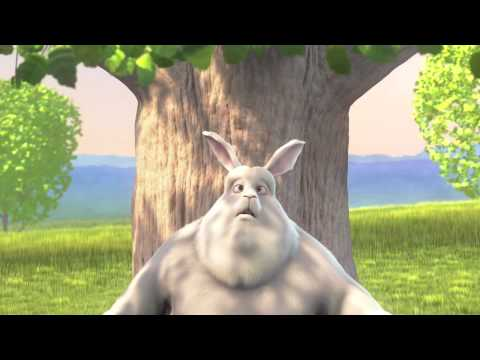

In [3]:
YouTubeVideo("YE7VzlLtp-4")
# Scenes:
# 

As you can notice, the video contains several semantic episodes, and within each episode several highlights or surprising events occur. In this lab, we will investigate to what extent structural segmentation and highlight detection could be performed based on audiovisual analysis.

We will initially consider the visual and audio domain separately in the analysis. For convenience, we already made a separate video and audio track available to you.

In [4]:
DATA_PATH = '/home/student/data/cs4065/mm_structure_analysis'

VIDEO_URL = 'https://www.dropbox.com/s/g8ta0t47hzz40u0/BigBuckBunny_video.mp4?dl=1'
VIDEO_PATH = os.path.join(DATA_PATH, 'BigBuckBunny_video.mp4')

AUDIO_URL = 'https://www.dropbox.com/s/doqcxtojqigo4s0/BigBuckBunny_audio.aac?dl=1'
AUDIO_PATH = os.path.join(DATA_PATH, 'BigBuckBunny_audio.aac')

def fetch_data(url, filepath):
  if os.path.exists(filepath):
    print('<{}> already available'.format(url))
    return filepath
  try:
    os.makedirs(os.path.dirname(filepath))
  except:
    pass
  print('fetching <{}>...'.format(url)),
  (filepath, _) = ur.urlretrieve(url, filepath)
  print('done!')
  return filepath


_ = fetch_data(VIDEO_URL, VIDEO_PATH)
_ = fetch_data(AUDIO_URL, AUDIO_PATH)

<https://www.dropbox.com/s/g8ta0t47hzz40u0/BigBuckBunny_video.mp4?dl=1> already available
<https://www.dropbox.com/s/doqcxtojqigo4s0/BigBuckBunny_audio.aac?dl=1> already available


## Video analysis
You will have to find shot/scene boundaries in the given video. To simplify our implementation, in this lab, we will extract a feature vector for each frame, and then compute a **full** self-similarity matrix.

Note that this approach is good for visualization, but not for efficiency. In case you would ever need to implement a more efficient solution, you can iterate over the frames using a buffer of past frames (or features derived from them), avoiding keeping them all in memory. Furthermore, self-similarity can efficiently be computed by using a circular buffer of feature vectors, and when you would be interested in novelty detection, it may be enough to restrict your analysis to a band close to the self-similarity matrix diagonal. If you are interested in how to implement this, see the documentation for <code>mirsimatrix()</code> in https://www.jyu.fi/hum/laitokset/musiikki/en/research/coe/materials/mirtoolbox/MIRtoolbox1.6.1guide (from page 163 on)---in particular, the "Width" option, which enables to restrict to a diagonal bandwidth only.

In any case, as said before, in the current lab, we will just consider a full analysis of our video.

### Reading a video
Below, we show how to read a video.

In [5]:
# Let's open the video and read its properties.
video_reader = VideoReader()
video_reader.open(VIDEO_PATH)

# Video duration (in seconds).
video_duration = float(
    video_reader.get_number_of_frames()) / float(video_reader.get_frame_rate())

print('resolution: {} x {}'.format(video_reader.get_width(), video_reader.get_height()))
print('number of frames: {}'.format(video_reader.get_number_of_frames()))
print('duration: {}'.format(datetime.timedelta(seconds=video_duration)))

resolution: 320 x 180
number of frames: 14315
duration: 0:09:56.458333


*The <code>VideoReader</code> class is very simple and has no <code>seek()</code> method. Therefore, the next frame to be read by VideoReader always is the next unread frame in the video. if you want to read the same video multiple times, you need to re-open it (and re-instantiate <code>video_reader</code> if you want to open the same video).*

We first examine a number of frames in the first 10 seconds of the video (feel free to experiment with the parameters).

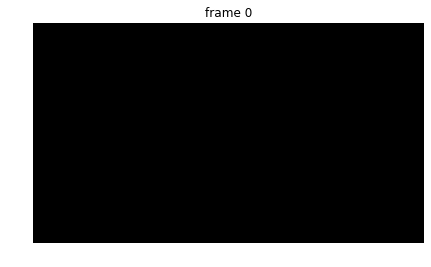

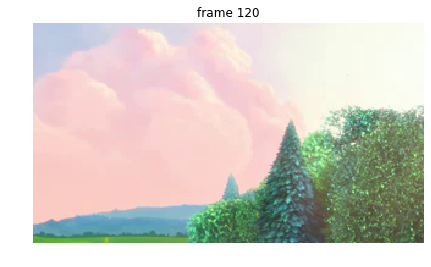

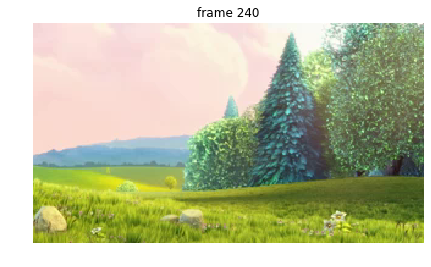

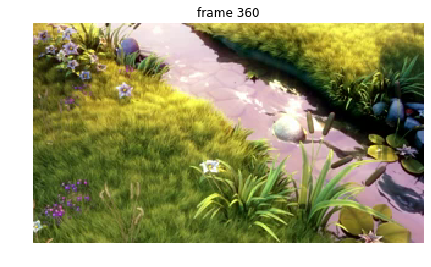

In [115]:
# Re-open the video to now process it from the start.
video_reader = VideoReader()
video_reader.open(VIDEO_PATH)

# Read a number of video frames (say, the first 10 seconds).
video_fps = video_reader.get_frame_rate()
sampling_period = int(5.0 * video_fps)  # One every 3 seconds.
stop_at = int(10.0 * video_fps)  # For the first 10 seconds.

%matplotlib inline

for frame in video_reader.get_frames():
  index = video_reader.get_current_frame_index()
  if 0 != index % sampling_period:
    continue
  ipynb_show_cv2_image(frame, 'frame %d' % index)
  if index > stop_at:
    break

### Extract frame features
We will now extract HS color histograms for each frame in the video and downsample the resulting feature matrix by retaining 1 histogram per second.

### Question
Complete the <code>extract_frame_hs_histogram()</code> function below, so it will extract HS color histograms. Use 8 bins for each channel when computing the histogram; the ranges for the H and S channels are 0-180 and 0-256 respectively.

*If you are lost, check back on what you did in the second lab assignment (week 2) of this course.*

NB: when computing your histogram, verify its dimensions with <code>np.shape()<code>. In case the histogram originally is stored as a matrix, use <code>np.flatten()</code> to make sure that you return a vector (and not a matrix).

In [69]:
def extract_frame_hs_histogram(frame):
  # TODO: replace empty list by actual histogram.
  histogram = []
  hsv_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
  range = [[0, 180], [0, 256]]
  # We generate a histogram per channel, and then add it to the single-vector histogram.
  for i in [0,1]:
    channel = frame[:,:,i]
    channel_range = range[i]


    channel_histogram = cv2.calcHist(
        [hsv_image],
        [i],
        None, # one could specify an optional mask here (we don't use this here),
        [8],
        channel_range
        )
    
    histogram = np.append(histogram, channel_histogram)

  return histogram / np.sum(histogram)  # Return a normalized histogram.


# Find the size of the hs histograms computed by extract_frame_hs_histogram().
# We do this by passing an 8x8 black patch.
histogram_size = len(extract_frame_hs_histogram(np.zeros((8, 8, 3), dtype=np.uint8)))
print('HS histogram size: {}'.format(histogram_size))

HS histogram size: 16


You now have to extract the matrix of HS histograms.

In [70]:
# Re-open the video to now process it from the start.
video_reader = VideoReader()
video_reader.open(VIDEO_PATH)

# Initialize the matrix (one row for each frame).
hs_histogram_matrix = np.zeros((
    video_reader.get_number_of_frames(), histogram_size))

# Compute features per frame. Note this will take some time.
for frame in video_reader.get_frames():
  index = video_reader.get_current_frame_index()
  hs_histogram_matrix[index, :] = extract_frame_hs_histogram(frame)

We now have a histogram per frame. We will resample the data to keep one value per second.

In [71]:
number_of_seconds = int(np.round(video_duration))
hs_histogram_matrix_resampled = np.array(resample(hs_histogram_matrix, number_of_seconds)).astype(np.float32)

print('HS histogram matrix size: {} x {}'.format(*np.shape(hs_histogram_matrix_resampled)))

# Remove the full size HS histogram matrix (we don't need it anymore).
del hs_histogram_matrix

HS histogram matrix size: 596 x 16


### Self-similarity analysis
To understand the structure of the video, we will proceed by conducting a self-similarity analysis. For any type of stream, the self-similarity matrix is computed using two "ingredients": (i) a matrix of feature vectors representing the stream and (ii) a similarity function to compare feature vector pairs.

### Question
Complete <code>hs_histograms_similarity()</code> (HS histograms similarity function) using the intersection area similarity metric. When passing numpy arrays to Open CV functions, cast them to float 32 using <code>my_array.astype(np.float32)</code>.

In [10]:
def hs_histograms_similarity(hs_histogram0, hs_histogram1):
    minima = np.minimum(hs_histogram0, hs_histogram1)
    intersection = np.true_divide(np.sum(minima), np.sum(hs_histogram1))
    return intersection

# Example.
print('100 vs 101: {0:.6f}'.format(hs_histograms_similarity(
    hs_histogram_matrix_resampled[100, :],
    hs_histogram_matrix_resampled[101, :])))

print('100 vs 105: {0:.6f}'.format(hs_histograms_similarity(
    hs_histogram_matrix_resampled[100, :],
    hs_histogram_matrix_resampled[105, :])))

100 vs 101: 0.921926
100 vs 105: 0.434970


We now will define a function called <code>compute_self_similarity</code> that computes a square self-similarity matrix, given a matrix of feature vectors that represents a stream (video, audio) over time.

The second parameter, named <code>similarity_function</code>, is a function handle that uses your <code>hs_histogram_similarity</code> function by default. You can however use any other similarity function of your choice. (If you would like to do this, do keep in mind that we want to measure *similarity* (and not distance))

### Question
Complete the <code>compute_self_similarity()</code> function below.

Some questions to think of when doing this:
- the result should be a matrix. What should be the dimensions of this matrix?
- what does each element in this matrix represent? Here, your similarity function will have to be used.

In [11]:
def compute_self_similarity(feature_vector_matrix, similarity_function = hs_histograms_similarity):
  # TODO: implement. 
  shape = feature_vector_matrix.shape
  x = np.zeros((shape[0], shape[0]))
  for i in range(shape[0]):
    for j in range(shape[0]):
     x[i,j] = similarity_function(feature_vector_matrix[i,:], feature_vector_matrix[j,:])
  # For calling the similarity function, you can just use similarity_function(first_vector, second_vector).
#   x = similarity_function(feature_vector_matrix, feature_vector_matrix)
#   print(x)
  return x

Let's now build the self-similarity matrix.

In [12]:
hs_histograms_self_similarity = compute_self_similarity(
    hs_histogram_matrix_resampled, hs_histograms_similarity)
print('HS histograms self-similarity matrix size: {} x {}'.format(*np.shape(hs_histograms_self_similarity)))

HS histograms self-similarity matrix size: 596 x 596


Subsequently, we will visualize the self-similarity matrix as an image.

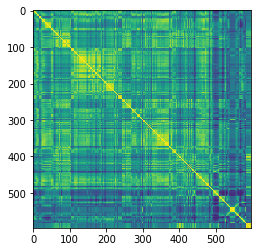

In [72]:
plt.figure()
plt.imshow(hs_histograms_self_similarity)

### Novelty curve
The self-similarity matrix shows blocks around the diagonal that correspond to regions of high self-similarity. As discussed in the lecture, detecting transitions between these blocks can point you to *novelty* points, indicating that a new coherent episode is starting. Therefore, we will now focus on extracting a *novelty curve*.

To this end, you have to create a 2D square *kernel* matrix of arbitrary size. It will be used to slide along the diagonal of the self-similarity matrix to compute the correlation with the block it lies on. Sliding along the diagonal corresponds to moving along the timeline of the analyzed stream.

We first show the *checkerboard kernel*; then, you will have to compute a smoother version of it called *Gaussian checkerboard kernel* (by completing <code>compute_gaussian_checkerboard_kernel()</code>).

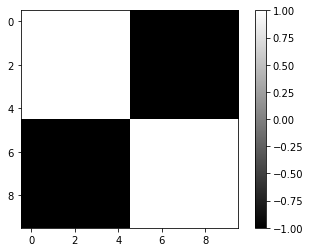

In [73]:
def compute_checkerboard_kernel(kernel_size = 10):
  # This is the size on a side of the kernel.
  kernel_side = int(np.ceil(kernel_size / 2.0))

  # Initialize.
  kernel = np.ones((kernel_size, kernel_size))
  
  # Set the top-right and bottom-left blocks to -1.
  kernel[0:kernel_side, kernel_side:] = -1.0
  kernel[kernel_side:, 0:kernel_side] = -1.0
  
  return kernel

fig = plt.figure('Checkerboard kernel')
cax = plt.imshow(
    compute_checkerboard_kernel(), interpolation='nearest', cmap='gray')
fig.colorbar(cax)

The Gaussian checkerboard kernel is a smoother version of the checkerboard kernel displayed above. Similarity values around its center are weighted more than those at the edges. Using this instead of the checkerboard kernel leads to a smoother novelty curve.

Use the following definition of 2D Gaussian (centered in the middle of the kernel) to complete <code>gaussian_checkerboard_kernel()</code>:

$$
f(x, y) = exp(- 4 \cdot [\frac{(x - \mu)^2}{\mu^2} + \frac{(y - \mu)^2}{\mu^2}])
$$

where $\mu$ is equal to <code>kernel_side</code> (see its value in <code>checkerboard_kernel()</code>).

*Tip: re-use <code>checkerboard_kernel()</code>.*

### Question
Complete <code>compute_gaussian_checkerboard_kernel()</code>.

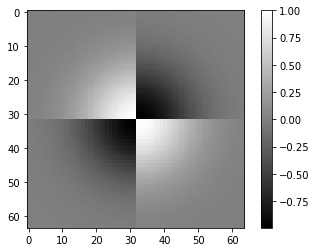

In [74]:
import math


def gauss(x, y, mu):
    return math.exp(-4 * ( (x - mu)**2 / mu**2 + (y - mu)**2/mu**2  ) )

def compute_gaussian_checkerboard_kernel(kernel_size = 10):
    # This is the size on a side of the kernel.
    kernel_side = int(np.ceil(kernel_size / 2.0))
    
    # Initialize.
    kernel = np.ones((kernel_size, kernel_size))
    
    # Set the top-right and bottom-left blocks to -1.
    kernel[0:kernel_side, kernel_side:] = -1.0
    kernel[kernel_side:, 0:kernel_side] = -1.0

    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] *= gauss(i, j, kernel_side)

    return kernel
                 
fig = plt.figure('Gaussian checkerboard kernel')
cax = plt.imshow(
    compute_gaussian_checkerboard_kernel(64), interpolation='nearest', cmap='gray')
fig.colorbar(cax)

As anticipated above, the last step is computing the correlation of the kernel with self-similarity blocks extracted along the diagonal. Note that the kernel always is centered around the time points it is targeting for calculation; as a consequence, its scope will slightly 'fall outside' the self-similarity matrix boundaries when targeting the very first and very last seconds of the video.

To deal with this, we will apply zero padding to the self-similarity matrix, adding extra zeros around the matrix to handle the boundary cases at the start and end of the analysis.

### Question
Complete the function <code>compute_novelty()</code>.

In [16]:
def compute_novelty(self_similarity_matrix, kernel):
  diag_length = np.shape(self_similarity_matrix)[0]
  kernel_size = np.shape(kernel)[0]
  kernel_size_half = int(np.ceil(kernel_size / 2.0))
  
  # Pad the self-similarity matrix.
  padded_size = diag_length + kernel_size  # TODO: the padding size is not zero. Replace this with the correct value

  padded_self_sim_matrix = np.zeros((padded_size, padded_size))
  stop = - kernel_size_half + int(1 == kernel_size % 2)
  padded_self_sim_matrix[
      kernel_size_half:stop,
      kernel_size_half:stop] = self_similarity_matrix
  
  # Compute novelty.
  novelty = np.zeros(diag_length)
  for x in range(diag_length):
    stop = kernel_size+x  # TODO: compute the first excluded index in the interval x:stop (see below).
    sub_block = padded_self_sim_matrix[x:stop, x:stop]
    novelty[x] = np.sum(sub_block * kernel)  # Correlation between the kernel and the subblock.
    
  return novelty

<IPython.core.display.Javascript object>


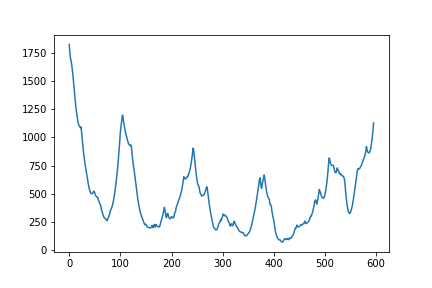

In [93]:
video_novelty = compute_novelty(
    hs_histograms_self_similarity, compute_gaussian_checkerboard_kernel(256))

plt.figure('Video Novelty')
plt.plot(video_novelty)

## Audio analysis
So far, we considered the video channel. We will now compute a novelty curve for the audio stream in similar fashion.

In general, long audio signals can efficiently be analyzed by using the sliding window technique: as shown in the picture below, the signal is split into (overlapping) frames of fixed size (which, for efficiency, is a power of 2) and each frame is analyzed independetly. The output is a list of feature vectors (one per frame).

<p style="text-align: center;"><a href="https://commons.wikimedia.org/wiki/File:Depiction_of_overlap-add_algorithm.png#/media/File:Depiction_of_overlap-add_algorithm.png"><img src="https://upload.wikimedia.org/wikipedia/commons/7/77/Depiction_of_overlap-add_algorithm.png" style="width: 640px" alt="Depiction of overlap-add algorithm.png"></a><br>By en:Bob K (modifications), <a href="//en.wikipedia.org/wiki/en:User:Paolostar" class="extiw" title="w:en:User:Paolostar">User:Paolostar</a>, Paolo Serena (original, released for free use) - en wikipedia, derived from <a href="//en.wikipedia.org/wiki/en:File:Oa_idea.jpg" class="extiw" title="w:en:File:Oa idea.jpg">w:en:File:Oa idea.jpg</a> by <a href="//en.wikipedia.org/wiki/en:User:Paolostar" class="extiw" title="w:en:User:Paolostar">User:Paolostar</a>, Paolo Serena, University of Parma (Italy), Public Domain, https://commons.wikimedia.org/w/index.php?curid=5015398</p>

### Reading an audio file
Let's read the audio file and print some of its properties.

In [18]:
audio_signal, sample_rate = librosa.core.load(AUDIO_PATH)

In [19]:
# Audio duration (in seconds).
number_of_audio_samples = len(audio_signal)
audio_duration = float(
    number_of_audio_samples / float(sample_rate))

print('sample rate: {}'.format(sample_rate))
print('number of samples: {}'.format(number_of_audio_samples))
print('duration: {}'.format(datetime.timedelta(seconds=audio_duration)))

sample rate: 22050
number of samples: 13146740
duration: 0:09:56.224036


In [20]:
# When defining the frame size, we want a frame with a length which is a power of 2
# (in order for Fast Fourier Transform techniques to be applicable).
# Let's add a function to find the smallest next power of 2 for a given number.

def next_pow_2(x):
    """Smallest next power of two of a given value x."""
    return 1 << (x - 1).bit_length()

In [21]:
# Sliding window analysis parameters.
audio_frame_size = next_pow_2(int(sample_rate / 4.0))  # i.e., about 0.25 seconds.
audio_hop_size = int(audio_frame_size / 2.0)  # i.e., 50% overlap.
print(' - sliding window analysis')
print('   frame size: {}'.format(audio_frame_size))
print('   hop size: {}'.format(audio_hop_size))

 - sliding window analysis
   frame size: 8192
   hop size: 4096


### Self-similarity analysis
We first compute the self-similarity matrix for an audio feature called Chroma (which was discussed in the lectures). Later on, you will have to do the same using MFCCs.

In [25]:
# Extract Chroma vectors.
chroma_matrix = librosa.feature.chroma_stft(
    audio_signal, n_fft=audio_frame_size, hop_length=audio_hop_size)

Reduce the data to process by resampling the feature matrix. We will keep one value per second.

In [26]:
number_of_seconds = int(np.round(audio_duration))
chroma_matrix_resampled = np.array(resample(chroma_matrix.transpose(), number_of_seconds))

print('Chroma feature matrix size: {} x {}'.format(*np.shape(chroma_matrix_resampled)))

# Remove the full size Chroma matrix (we don't need it anymore).
del chroma_matrix

Chroma feature matrix size: 596 x 12


### Question
Compute and plot the Chroma self-similarity matrix using the cosine distance. To do that, replace the empty matrix below by the actual self-similarity matrix. Feel free to create a helper function for this. Also note that you could use pdist() (as you did in the very first lab) as an intermediate step, but then you would still have to convert dissimilarity into similarity. 

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(a, b):
    return 1 - distance.cosine(a,b)

chroma_self_similarity = compute_self_similarity(chroma_matrix_resampled, cosine_sim) # TODO: replace this empty matrix by an actual self-similarity matrix.

print('Chroma self-similarity matrix size: {} x {}'.format(*np.shape(chroma_self_similarity)))

Chroma self-similarity matrix size: 596 x 596


<IPython.core.display.Javascript object>


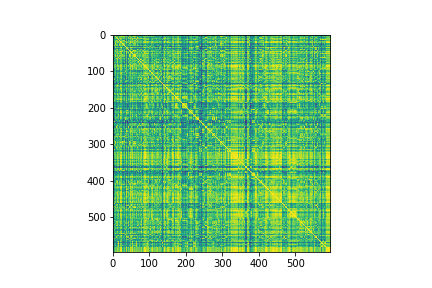

In [78]:
# inspect the results visually
%matplotlib notebook

plt.figure()
plt.imshow(chroma_self_similarity)

### Question
Extract the MFCCs matrix for the audio recording using <code>librosa.feature.mfcc()</code>. Remember to subsample the full matrix as done for Chroma. 

In [29]:
# Extract MFCCs vectors.
mfccs_matrix = librosa.feature.mfcc(
    audio_signal, n_fft=audio_frame_size, hop_length=audio_hop_size)
number_of_seconds = int(np.round(audio_duration))
mfccs_matrix_resampled = np.array(resample(mfccs_matrix.transpose(), number_of_seconds))

# Subsample.
# mfccs_matrix_resampled = []  # TODO: complete.

print('MFCCs feature matrix size: {} x {}'.format(*np.shape(mfccs_matrix_resampled)))

# Remove the full size Chroma matrix (we don't need it anymore).
del mfccs_matrix

MFCCs feature matrix size: 596 x 20


### Question
Compute the MFCC self-similarity matrix.

In [30]:
mfccs_self_similarity =  compute_self_similarity(mfccs_matrix_resampled, cosine_sim) # TODO: complete.
print('MFCCs self-similarity matrix size: {} x {}'.format(*np.shape(mfccs_self_similarity)))

MFCCs self-similarity matrix size: 596 x 596


<IPython.core.display.Javascript object>


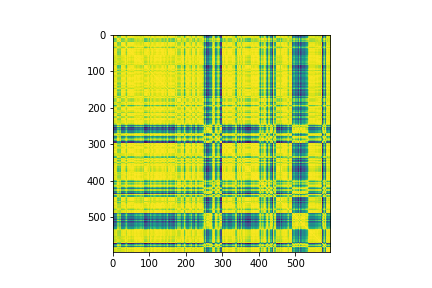

In [79]:
plt.figure()
plt.imshow(mfccs_self_similarity)

### Question
Choose to use either <code>chroma_self_similarity</code> or <code>mfccs_self_similarity</code> to extract novelty and motivate your choice.

In [32]:
# TODO: make your choice by uncommenting one of the following two lines.
audio_self_similarity = mfccs_self_similarity
# audio_self_similarity = chroma_self_similarity

### Novelty curve
Use the chosen self-similarity matrix to derive a novelty curve for the audio stream.

### Question
Extract the novelty curve. Try different kernel sizes.

<IPython.core.display.Javascript object>


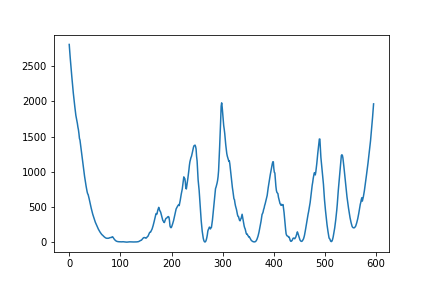

In [92]:
audio_novelty = compute_novelty(audio_self_similarity, compute_gaussian_checkerboard_kernel(256))  # TODO: complete.

plt.figure('Audio Novelty')
plt.plot(audio_novelty)

# Finding scenes via analysis of the novelty curves.
Above, you have extracted two novelty curves (namely, <code>audio_novelty</code> and <code>video_novelty</code>). The peaks in those signals can be interpreted as *boundaries* between shots/scenes. Depending on the parameters you chose above, you will found the strongest peaks at different locations.

The two novelty signals may be complementary: that is, they may reflect different types of episodical changes. As final step, you therefore will combine the two novelty signals, extract its peaks and spot the strongest ones by visual inspection of the plots.

First, we create a scaling function for the novelty vectors. We do this as a normalization step, to ensure both vectors are in similar range.

In [34]:
def scale_vector(v):
  return (v - np.min(v)) / (np.max(v) - np.min(v))

Then, we create a function that detects peaks in a vector. 

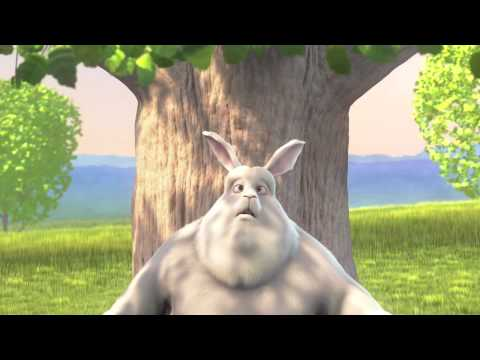

In [98]:
def detect_peaks(data, threshold = None):
  # Use scipy.signal.find_peaks_cwt to detect peaks.
  peaks_positions = np.array(
      find_peaks_cwt(data, np.arange(1, 10)))

  if 0 == len(peaks_positions):
    return []

  if threshold is not None:
    # Filter peaks by thresholding.
    mask = data[peaks_positions] > threshold
    peaks_positions = peaks_positions[mask]
  
  return peaks_positions

YouTubeVideo("YE7VzlLtp-4")

In [169]:
# Parameters
audio_self_similarity = mfccs_self_similarity
# audio_self_similarity = chroma_self_similarity
audio_novelty = compute_novelty(audio_self_similarity, compute_gaussian_checkerboard_kernel(256))
video_novelty = compute_novelty(hs_histograms_self_similarity, compute_gaussian_checkerboard_kernel(512))

number of video boundaries: 6
number of audio boundaries: 7
0:00:04
0:00:21
0:04:07
0:04:58
0:04:59
0:08:10
0:09:52


Text(0, 0.5, 'Audio Novelty')

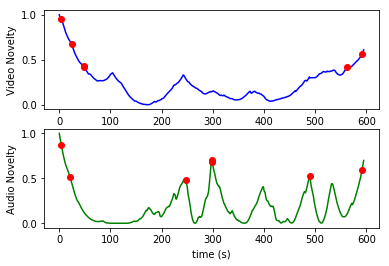

In [170]:
video_novelty_normalized = scale_vector(video_novelty)
video_boundaries = detect_peaks(video_novelty_normalized, 0.4)
print('number of video boundaries: {}'.format(len(video_boundaries)))

audio_novelty_normalized = scale_vector(audio_novelty)
audio_boundaries = detect_peaks(audio_novelty_normalized, 0.45)
print('number of audio boundaries: {}'.format(len(audio_boundaries)))

fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot(video_novelty_normalized, 'b')
plt.plot(video_boundaries, video_novelty_normalized[video_boundaries], 'or')
plt.xlabel('time (s)')
plt.ylabel('Video Novelty')

import datetime
for sec in audio_boundaries:
    print(str(datetime.timedelta(seconds=int(sec))))

plt.subplot(2, 1, 2)
plt.plot(audio_novelty_normalized, 'g')
plt.plot(audio_boundaries, audio_novelty_normalized[audio_boundaries], 'or')
plt.xlabel('time (s)')
plt.ylabel('Audio Novelty')

Let's combine the two novelty curves. Below, you find two possible ways. Feel free to test different options.

number of soft-and boundaries: 3
number of soft-or boundaries: 7


Text(0, 0.5, 'Soft-or Novelty')

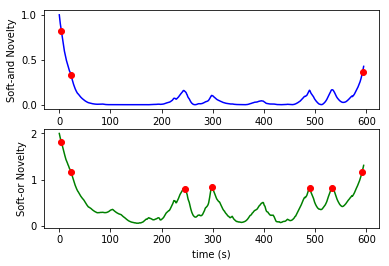

In [171]:
# Soft-and merging. If novelty is high in both signals, the combined result will be high.
# However, if it is high in one signal but low in the other, the combined result will be penalized.
soft_and_novelty = video_novelty_normalized * audio_novelty_normalized
soft_and_boundaries = detect_peaks(soft_and_novelty, 0.3)
print('number of soft-and boundaries: {}'.format(len(soft_and_boundaries)))

# Soft-or merging. If novelty is high in at least one of the signals, the combined result will be high.
soft_or_novelty = video_novelty_normalized + audio_novelty_normalized
soft_or_boundaries = detect_peaks(soft_or_novelty, 0.6)
print('number of soft-or boundaries: {}'.format(len(soft_or_boundaries)))

fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot(soft_and_novelty, 'b')
plt.plot(soft_and_boundaries, soft_and_novelty[soft_and_boundaries], 'or')
plt.xlabel('time (s)')
plt.ylabel('Soft-and Novelty')

plt.subplot(2, 1, 2)
plt.plot(soft_or_novelty, 'g')
plt.plot(soft_or_boundaries, soft_or_novelty[soft_or_boundaries], 'or')
plt.xlabel('time (s)')
plt.ylabel('Soft-or Novelty')

# What to hand in

Based on the analysis so far, you can conduct different types of multimodal structural analyses on the Big Buck Bunny video. As you noticed, the default analysis we conducted so far may not be optimal yet though.

Play with parameter settings, different analysis window sizes, audio feature types, and similarity metrics to see if you can detect the strongest episodical changes in the video based on video and audio content in a better way than done so far in the lab.

As an alternative (or complement) to novelty point analysis from a self-similarity matrix, you may also want to look at feature statistics *within* episode blocks over time. For example, you could investigate audio loudness, which you can calculate using <code>librosa.feature.rmse</code>, or consider how shot boundary density evolves over the timeline of the video.

To demonstrate you completed this assignment, please upload a file [studentNumberMember1_studentNumberMember2.pdf] to Brightspace in which you include the following:

- three detected *scene* boundaries in the video (formatted as hh:mm:ss) indicating the strongest episodical changes in the video used in this lab. Discuss what parameters and audio features you used to detect them (e.g., threshold choices, choice of audio feature, choice of similarity metric), and shortly discuss what content is displayed within the shots across these boundaries.
- your ideas on what further features could contribute to picking scene boundaries with strong episodical changes in the Big Buck Bunny video.